## Import "big random" files

- notebook author: melissa
- data author: claudio
- special mention: kostya was super helpful for this whole thing.
- date: july 18, 2024

Each file looks like it's random points generated within the same rectangle on the sky. By including more files, you get a denser sky in the same region. This imports three sets of files to be used for different catalog purposes:

* 10 files - a "galaxy" catalog
* 100 files - a "random" catalog
* all 501 files - a just very big catalog for stress-testing our approach.

In [1]:
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.pipeline import pipeline_with_client
from dask.distributed import Client

import hipscat
from hipscat.inspection import plot_pixels

from pathlib import Path
import os

/jet/home/delucchi/.conda/envs/hipscatenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CorrgiRandNumpyReader

This is an annoying part of working within a jupyter notebook: the `file_reader` argument is pickled, and if you create a custom implementation, you have to import it from a module. So, in this directory, I also have a file `corrgi_reader.py` with the following contents:

```
import numpy as np
import pandas as pd
from hipscat_import.catalog.file_readers import InputReader


class CorrgiRandNumpyReader(InputReader):
    def read(self, input_file, read_columns=None):
        data = np.load(input_file)
        yield pd.DataFrame(data, columns=["ra", "dec", "z", "weight"])
```

In [2]:
from corrgi_reader import CorrgiRandNumpyReader

In [3]:
input_files = sorted(Path("/ocean/projects/phy210048p/shared/bigrand_corrgi/").glob("big_random_part_*.npy"))
len(input_files)

501

On PSC, the local directory for the node is provided in this `$LOCAL` variable. Useful for telling dask where to dump files.

In [4]:
local_tmp = os.path.expandvars("$LOCAL")
local_tmp

'/local'

In [5]:
client = Client(n_workers=4, threads_per_worker=1, local_directory=local_tmp)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 247.07 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44167,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 247.07 GiB
Comm: tcp://127.0.0.1:34967,Total threads: 1
Dashboard: http://127.0.0.1:44951/status,Memory: 61.77 GiB
Nanny: tcp://127.0.0.1:39961,


In [ ]:
args = ImportArguments(
    ra_column="ra",
    dec_column="dec",
    input_file_list=input_files[:10],
    tmp_dir=local_tmp,
    file_reader=CorrgiRandNumpyReader(),
    output_artifact_name="big_rand_10",
    output_path="/ocean/projects/phy210048p/shared/corrgi/bigrand/",
    simple_progress_bar=True,
)

pipeline_with_client(args, client)

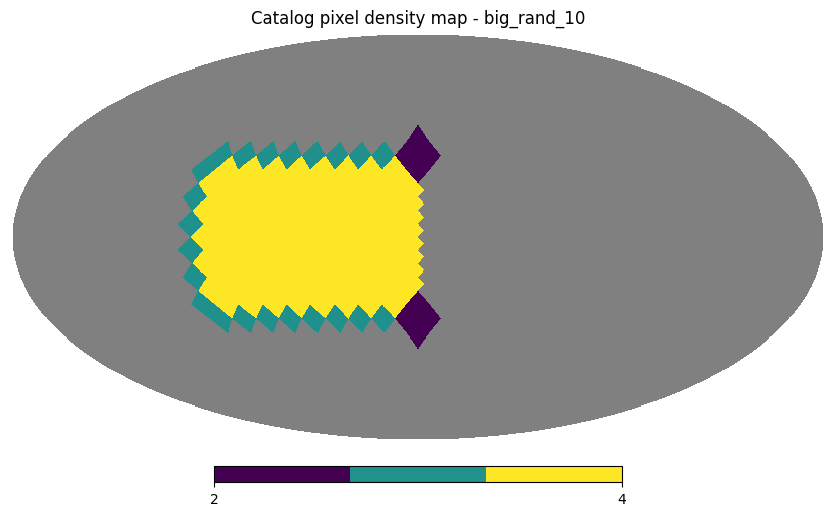

In [6]:
catalog = hipscat.read_from_hipscat("/ocean/projects/phy210048p/shared/corrgi/bigrand/big_rand_10")
plot_pixels(catalog)

In [7]:
args = ImportArguments(
    ra_column="ra",
    dec_column="dec",
    input_file_list=input_files[:100],
    tmp_dir=local_tmp,
    file_reader=CorrgiRandNumpyReader(),
    output_artifact_name="big_rand_100",
    output_path="/ocean/projects/phy210048p/shared/corrgi/bigrand/",
    simple_progress_bar=True,
    completion_email_address="delucchi@andrew.cmu.edu",
    resume=False,
)

pipeline_with_client(args, client)

Finishing : 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


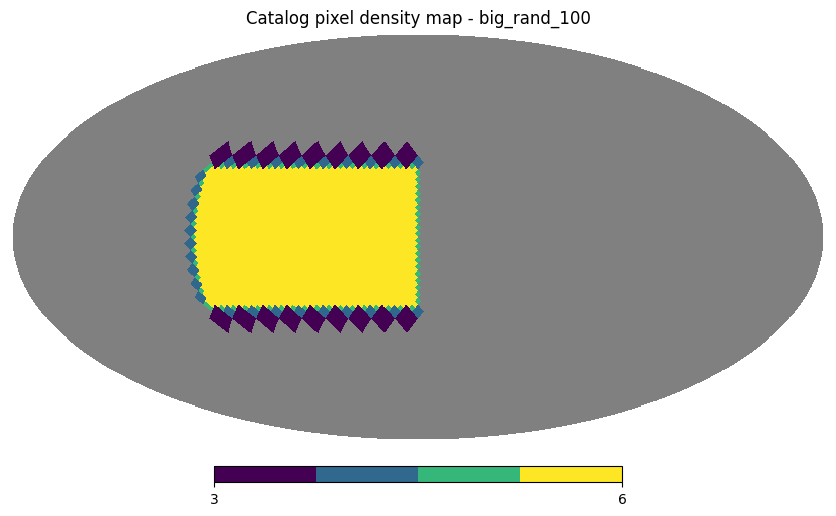

In [7]:
catalog = hipscat.read_from_hipscat("/ocean/projects/phy210048p/shared/corrgi/bigrand/big_rand_100")
plot_pixels(catalog)

In [ ]:
args = ImportArguments(
    ra_column="ra",
    dec_column="dec",
    input_file_list=input_files,
    tmp_dir=local_tmp,
    file_reader=CorrgiRandNumpyReader(),
    output_artifact_name="big_rand_all",
    output_path="/ocean/projects/phy210048p/shared/corrgi/bigrand/",
    simple_progress_bar=True,
    completion_email_address="delucchi@andrew.cmu.edu",
)

pipeline_with_client(args, client)

Splitting :   1%|          | 3/501 [23:21<43:32:50, 314.80s/it]  

In [ ]:
catalog = hipscat.read_from_hipscat("/ocean/projects/phy210048p/shared/corrgi/bigrand/big_rand_all")
plot_pixels(catalog)

In [ ]:
client.close()